In [1]:
# Initial setup

try:
    plt_inline
except NameError:
    ## Matplotlib one-time configuration
    %matplotlib inline
    plt_inline = True
    
from inc.cache_effect import *

In [2]:
# Show when it happens in profiling and "full" execution.

In [37]:
def input2samples(apps):
    def unique_input_sizes(apps):
        return set(a.stages[0].bytes_read for a in apps)
    
    b2s = {}
    k_samples = 32  # in thousands
    for byetes in sorted(unique_input_sizes(apps)):
        b2s[byetes] = k_samples
        k_samples *= 2

    # TODO get records read in stage 0
    samples = [32000, 64000, 128000, 256000, 512000, 1024000,
               2048000, 4096000, 16384000, 65536000]
    b2s = {_size:_samples/1000 for _size, _samples in zip(
           sorted(unique_input_sizes(apps)), samples)}
    
    return lambda b: b2s[b]

def is_target(app):
    return app.stages[0].bytes_read > 8 * 10**6

def get_df_records(apps, to_samples):
    ns_stages = set(len(app.stages) for app in apps)
    assert len(ns_stages) == 1
    n_stages = ns_stages.pop()
    # ['workers', 'samples', 'stage0read', 'stage0written', 'stage1read', ...]
    cols = ['workers', 'samples'] + ['stage{:d}{}'.format(stage, typ)
                                     for stage in range(n_stages)
                                     for typ in ('read', 'written')]
    rows = []
    for app in apps:
        row = [app.slaves, to_samples(app.stages[0].bytes_read)]
        for stage in app.stages:
            row.extend([stage.bytes_read / 1024, stage.bytes_written / 1024])
        rows.append(row)
    return rows, cols

In [2]:
## Load K-means experiments
parser = SparkParser()
apps = tuple(parser.parse_folder('data/hibench/kmeans'))

In [38]:
to_samples = input2samples(apps)
#target_apps = [app for app in apps if is_target(app)]
records, cols = get_df_records(apps, to_samples)
df = pd.DataFrame.from_records(records, columns=cols)

In [35]:
def find_app():
    slaves = 8
    uniq_inputs = sorted(set(a.stages[0].bytes_read for a in apps))
    input_size = uniq_inputs[-1]
    
    my_app = None
    for app in target_apps:
        if app.slaves == slaves and app.stages[0].bytes_read == input_size:
            my_app = app
            break
    if my_app is None:
        print('Could not find')
    else:
        print('slaves: {:d}'.format(my_app.slaves))
        print('samples: {:d}k'.format(to_samples(input_size)))
        print('filename: ' + my_app.filename)

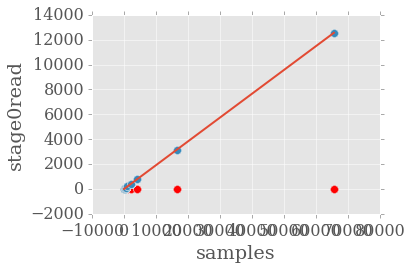

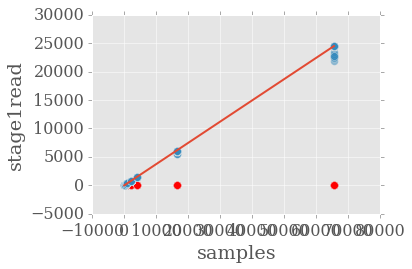

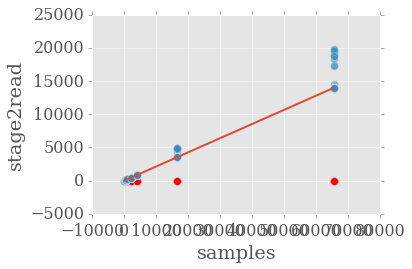

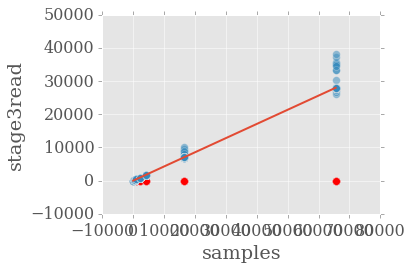

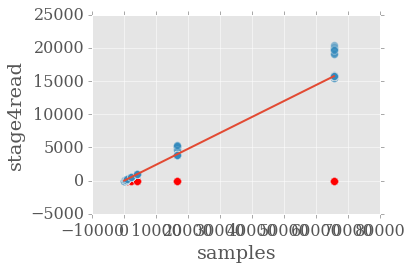

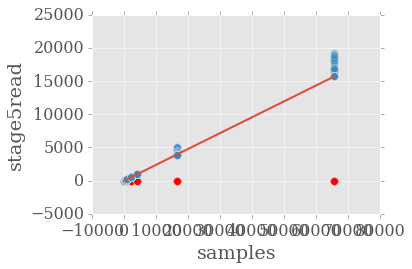

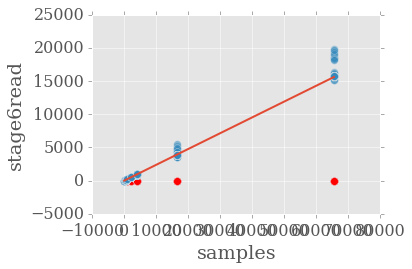

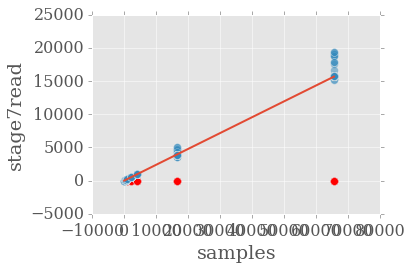

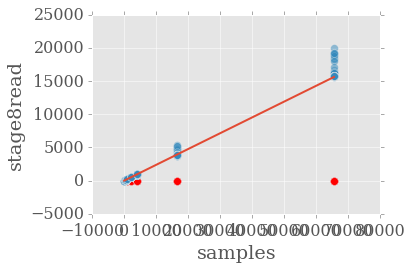

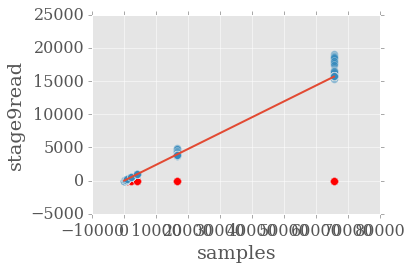

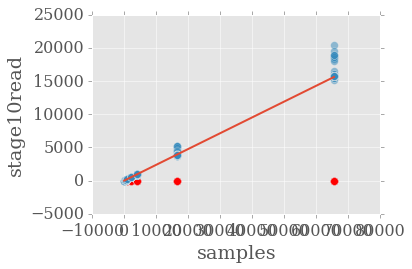

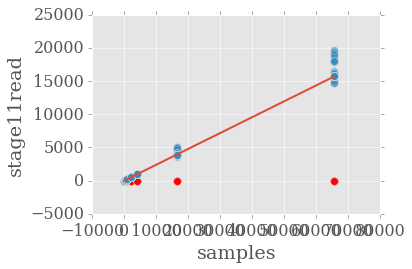

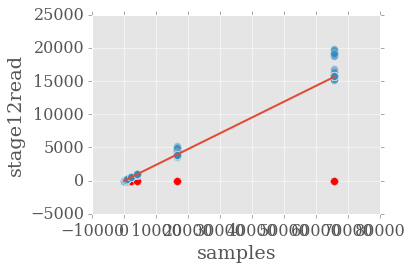

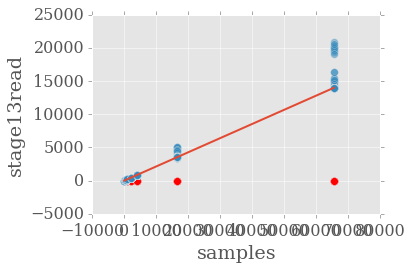

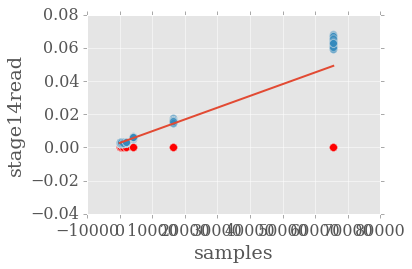

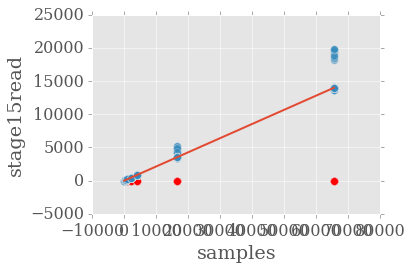

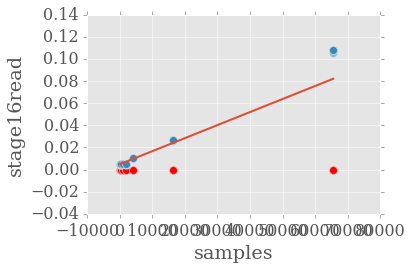

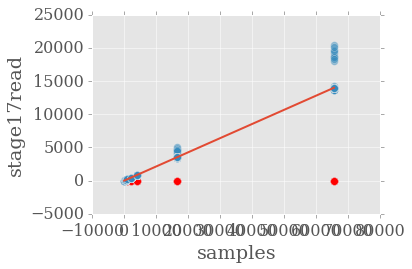

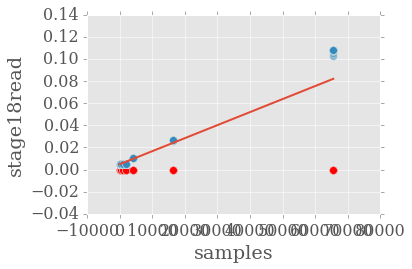

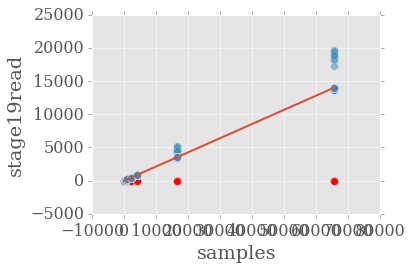

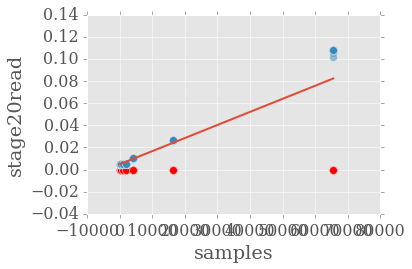

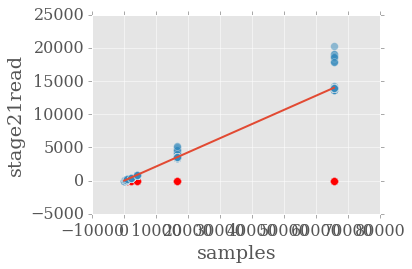

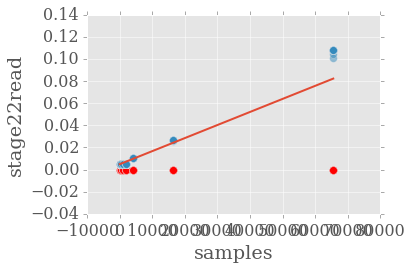

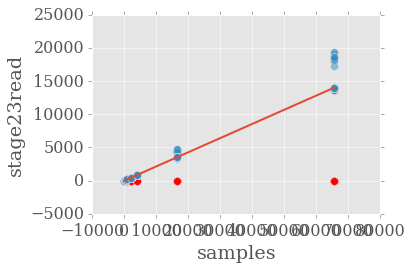

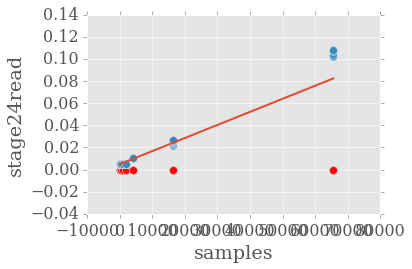

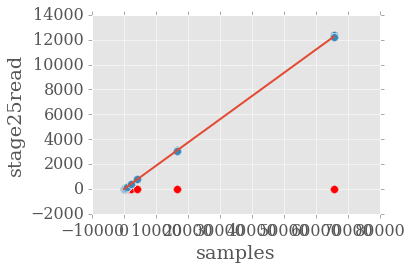

In [44]:
# Build graphs to understand how data grows as we increase the number of samples
# - Select a stage
# - Consider all number of workers
# - x: number of samples
# - y1: data read (scatterplot)
# - y2: data written (scatterplot)
def plot_stage(stage_id):
    x = 'samples'
    y1 = 'stage{:d}read'.format(stage_id)
    y2 = 'stage{:d}written'.format(stage_id)
    graph_df = pd.DataFrame()
    _df = df#[df[x] < 8192]
    graph_df[x] = _df[x]
    graph_df[y1] = _df[y1] / 1024  # to MB
    graph_df[y2] = _df[y2] / 1024  # to MB
    alpha=0.5
    
    ax = graph_df.plot.scatter(x, y2, s=60, c='r', alpha=alpha)
    graph_df.plot.scatter(x, y1, s=60, alpha=alpha, ax=ax)
    
    prof_df = graph_df[[x, y1]][graph_df.samples < 8000]
    x_max = graph_df[x].max()
    plot_data_size_prediction(ax, prof_df, x_max)
    
    plt.tight_layout()
    plt.show()
    
    #list_points(graph_df[[x, y1]])
    #list_points(graph_df[[x, y2]])
    
import numpy as np

def plot_data_size_prediction(ax, df, x_max):
    x, y = df.columns
    z = np.polyfit(df[x], df[y], 1)
    p = np.poly1d(z)
    xs = np.linspace(0, x_max, x_max)
    ax.plot(xs, p(xs))
    
from IPython.display import display
    
def list_points(df):
    col1, col2 = df.columns
    counts = df.groupby(col1).apply(lambda x: x[col2].value_counts())
    display(counts)

import matplotlib.pyplot as plt
    
for stage in range(len(apps[0].stages)):
    plot_stage(stage)
    

In [40]:
_df = df[['samples', 'stage0read']].groupby('samples').mean().reset_index()
_df['samples/read'] = 200 * _df.samples / _df.stage0read
_df

,samples,stage0read,samples/read
0,32.00,6275.97,1.02
1,64.00,12551.55,1.02
2,128.00,25102.72,1.02
3,256.00,50204.97,1.02
4,512.00,100409.56,1.02
5,1024.00,200818.64,1.02
6,2048.00,401636.81,1.02
7,4096.00,803279.60,1.02
8,16384.00,3213128.16,1.02
9,65536.00,12852530.90,1.02


In [ ]:
_df = pd.DataFrame()
_df['samples'] = [input2samples(a.stages[0].bytes_read) for a in apps]
_df['']